# Session I - Bloqade activities

This notebook accompanies the Session I of QuEra's condensed tutorial on neutral-atom quantum computing and intends to provide participants with the basic information needed to control neutral-atom quantum Hamiltonians.

## Installation requirements and guidelines
For general details on Bloqade's functionality, we refer the reader to the [Bloqade documentation page](https://queracomputing.github.io/Bloqade.jl/dev/). 

To operate this tutorial notebook, you will need `Julia` (to operate Bloqade) and `Python` (for plotting). It will be necessary to `IJulia` for interactive notebooks. Installation guidelines can be found [here](https://datatofish.com/add-julia-to-jupyter/) and boil down to [installing Julia](https://julialang.org/downloads/) and running `using Pkg; Pkg.add("IJulia")` on your Julia terminal. Once IJulia is installed, you can add Bloqade directly from this notebook by running `using Pkg; Pkg.add("Bloqade")`.

A couple of other necessary dependencies are `Graphs` (`using Pkg; Pkg.add("Graphs")`) and `PythonCall` (`using Pkg; Pkg.add("PythonCall")`)

With the house in order, now let's have fun!

## Quantum simulations in 5 steps

Solving problems with a Rydberg analog simulator is different from doing quantum computing with gates. Qubit interactions and connectivity can be defined ad-hoc, the user may literally define what their processor looks like, and a clear knowledge of the Hamiltonian that control the qubit dynamics is needed.

We will get back to these details in a second. First, let's focus on workflow. The process of encoding a problem in a neutral-atom analog simulator involves 5 general steps:

1. Define the atoms/qubits positions
2. Define time traces of Hamiltonian parameters (i.e., the algorithm)
3. Initialize the problem (starting qubit register and Hamiltonian)
4. Perform time evolution (the analogue of composing gates)
5. Measure for results

Not too bad! In what follows, we will focus on point 1 and 2, while Session II of our tutorial will cover packing it all together into some applications that will cover all steps together.

## The Hamiltonian

The steps above come together as a way to conduct the atomic qubits according to their natural interactions. These interactions and the subsequent dynamics, are controlled by an energy function, known as a Hamiltonian, which in Bloqade and several neutral-atom simulators, is as follows,

$$
\frac{\mathcal{H}(t)}{\hbar} = \sum_j \frac{\Omega_j(t)}{2} \left( e^{i \phi_j(t) } | 0_j \rangle  \langle 1_j | + e^{-i \phi_j(t) } | 1_j \rangle  \langle 0_j | \right) - \sum_j \Delta_j(t) \hat{n}_j + \sum_{j < k} V_{jk} \hat{n}_j \hat{n}_k,
$$

where $| 0_i \rangle,$  $| 1_i \rangle,$ and $\hat{n}_i= 0|0_i \rangle  \langle 0_i | + 1| 1_i \rangle  \langle 1_i | $  refer to qubits in a position $i$ of space. Referring to step 1 in the previous section, the user's first job is to define, geometrically (in micrometers for Bloqade), what are the allowed positions. Bloqade accepts nearly arbitrary geometries in 2D, following the constraints of several real neutral-atom quantum processors available nowadays. 

Fixing these geometric positions is crucial because the interaction term between qubits $i$ and $j$, $V_{ij}$, decays with the distance between the qubits to the 6th power. This interaction imparts a positive energy cost to the Hamiltonian, meaning that if qubits are too close, effectively, the state where both qubits are $1$ has too much energy to be accessed and is effectively expelled from the Hilbert space (this is called the Rydberg blockade mechanism). 

Naturally the story above is a bit simplified. Defining algorithms, our step 2 above, requires manipulating the time-traces of the Hamiltonian parameters $\Omega_i(t)$, $\phi_i(t)$, and $\Delta_i(t)$. The Rabi term $\Omega$ and detuning $\Delta$ introduce energy scales that compete with the geometrically controlled scale $V_{ij}$.


In a real device, like Aquila, constraints exist for the values of position and time-dependent functions. If you intend to create simulations that can be deployed on real hardware, make sure to consult the capabilities documented [here](https://queracomputing.github.io/Bloqade.jl/dev/capabilities/). The examples below will be following the limitations imposed by the hardware.

From here on, we move to real practice.

*disclaimer: note that Julia is slow the first time it runs a problem, due to pre-compilation. It will run fast after a first run through a calculation.*

### Preparations

To get started let's include some packages that will be useful.

In [15]:
using Graphs
using Bloqade
using Random
using PythonCall
plt = pyimport("matplotlib.pyplot");

# I. Geometric controls

To determine the position of atoms, the key object is called `AtomList`. You construct one by providing as input a set of ordered pairs corresponding to the positions of our qubits in a cartesian plane (in $\mu$m units), for example:

In [20]:
atom_coordinate = AtomList([(0.0, 0.0), (0, 5), (0, 8), (5, 2), (6, 7), (9, 6)]);

we can extract the input that Bloqade will actually take by writing

In [21]:
atom_coordinate.atoms

6-element Vector{Tuple{Real, Real}}:
 (0.0, 0.0)
 (0, 5)
 (0, 8)
 (5, 2)
 (6, 7)
 (9, 6)

and simply typing our object name `atom_coordinate` and running the cell gives us a graphical representation of our qubit placement

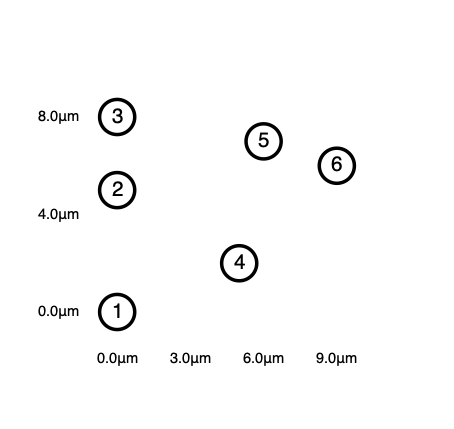

In [22]:
atom_coordinate

### Exercise:

Check the hand-out for the MIS activity. We will look at it more carefully on Session II of this tutorial. Fow now, let's just practice creating a register with qubits in the positions corresponding to the 9 vertices of the graph of the handout

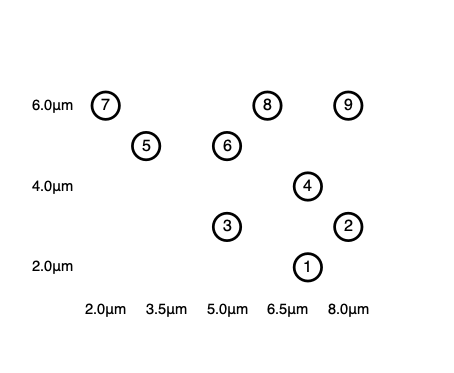

In [23]:
# solution
UDG_coordinates = AtomList([(7.0, 2.0), (8.0,3.0), (5.0,3.0), (7.0, 4.0), (3.0,5.0), (5.0,5.0), (2.0,6.0), (6.0,6.0), (8.0,6.0)])

Quite often, the positioning of qubits of interest follows a regular lattice pattern. Bloqade has shorthand lattice types for several useful lattices, including the `ChainLattice`, `SquareLattice`, `HoneycombLattice`, `TriangularLattice`, `LiebLattice`, and `KagomeLattice`. When using these, we rely on the helper function `generate_sites` which takes as input a lattice geometry among the ones above, the number of atoms desired in rows and columns and returns an `AtomList` instance with the appropriate geometric information. `generate_sites` can also take a length scale (in $\mu m$) for the lattice constant (for geometric definitions, look for introductory literature on Bravais lattices). 

Here goes an example

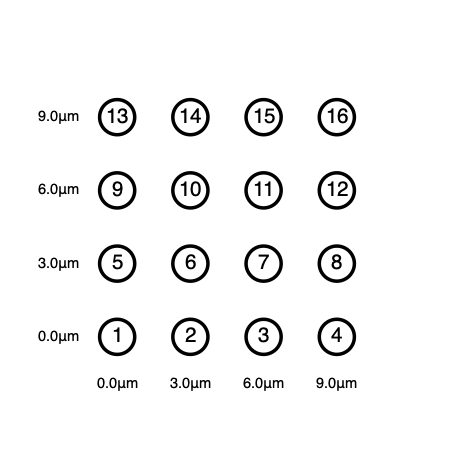

In [25]:
generate_sites(SquareLattice(),4,4, scale=3)

### Exercise:

Pick up one of the pre-defined user lattices of your choice and plot it. Discuss with your neighbor what kind of application you believe that lattice can be useful for and why you made that choice.

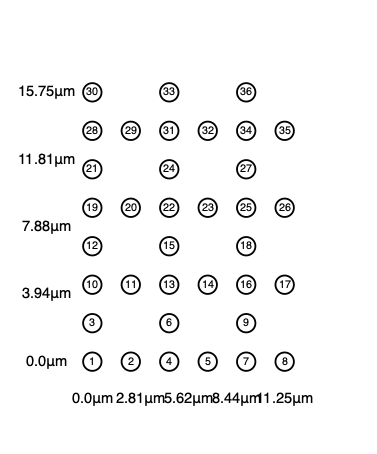

In [7]:
# solution: no right/wrong answer

generate_sites(LiebLattice(),3,4, scale=4.5)

Bloqade facilitates many more manipulations on qubit register geometries. For more information check this [documentation](https://queracomputing.github.io/Bloqade.jl/dev/lattices/) page.

# II. Dynamic controls

Generating waveforms is the essential step for generating and controlling a neutral-atom analog quantum processor. As discussed before, the parameters that can be determined by the user for different quantum protocols include the Rabi frequencies Ω, the detuning field Δ, and the phase ϕ. 

While Bloqade supports several built-in waveforms and allows the users to specify smooth waveforms by inputting functions, machine constraints dictate that piecewise linear and piecewise constant functions are the most relevant ones for real-world applications that can run on actual quantum devices.

Let's see how to compose piecewise linear and constant functions and plot them with Bloqade! (note Bloqade calls [`matplotlib`](https://matplotlib.org/) under the hood to help with plotting)

`piecewise_linear` takes as inputs a list of "clocks", the values at which each piecewise linear segment begins and ends. Furthermore, it takes a set of values for the begining and ending of each linear segment. Bloqade uses native units for its waveforms that facilitate aligning with hardware constraints, so that the waveform values are measured in units of MHz

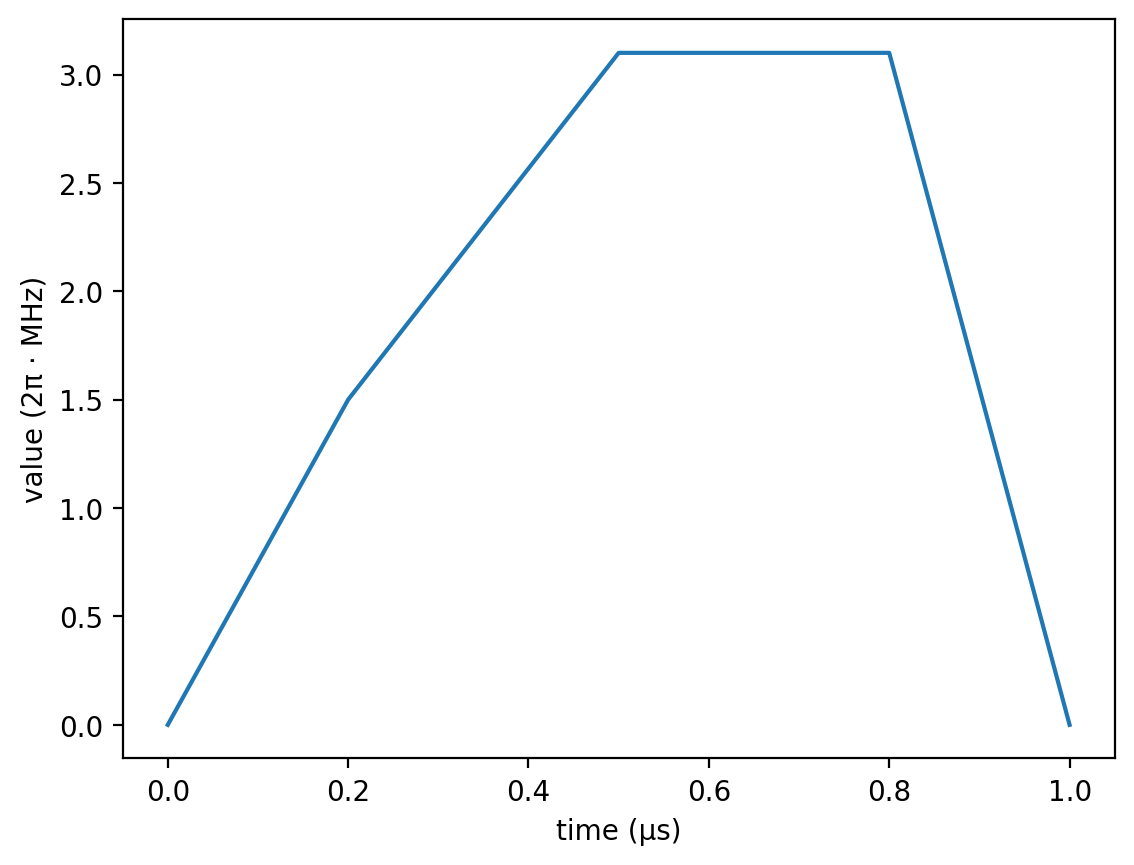

In [10]:
waveform = piecewise_linear(clocks=[0.0, 0.2, 0.5, 0.8, 1.0], values= 2π* [0.0, 1.5, 3.1, 3.1, 0.0]);
Bloqade.plot(waveform)

`piecewise_constant` operates much in a similar way. For example,

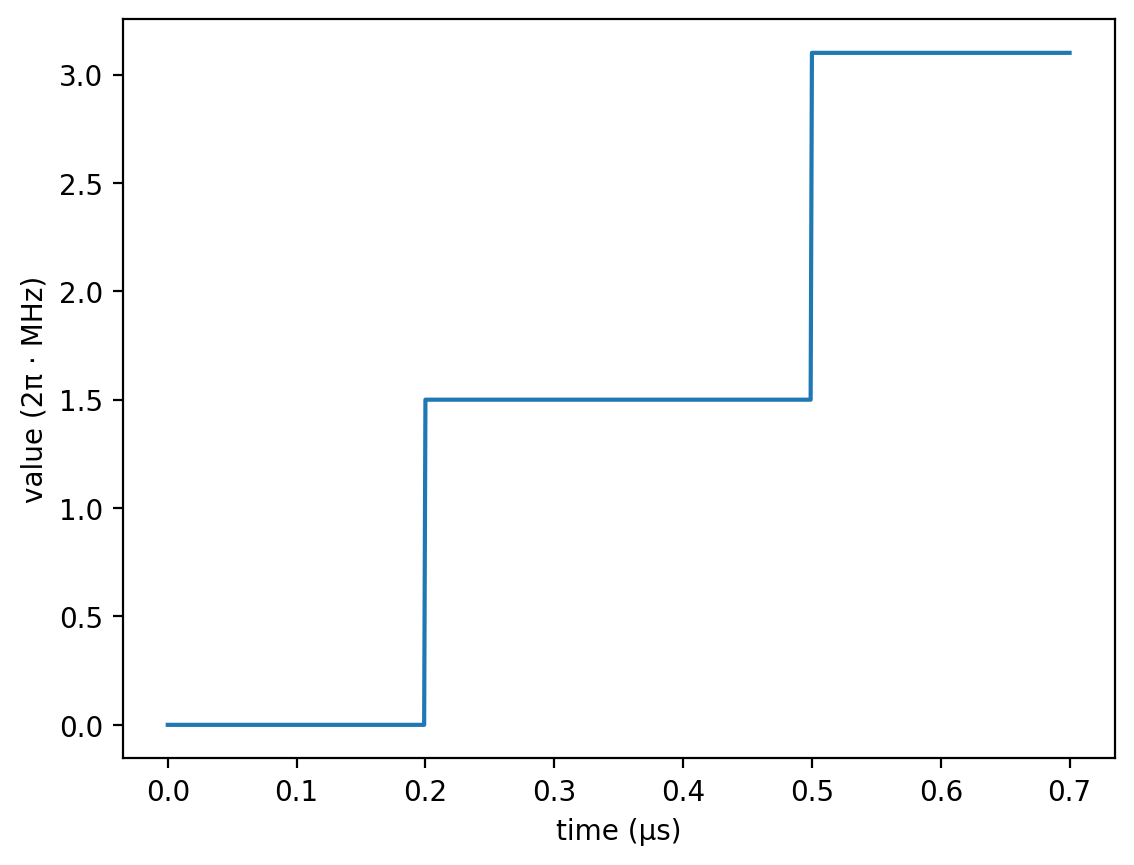

In [11]:
waveform = piecewise_constant(clocks=[0.0, 0.2, 0.5, 0.7], values= 2π*[0.0, 1.5, 3.1]);
Bloqade.plot(waveform)

### Exercise

Study the following waveform profiles and determine for which type of algorithmic protocols they may be used for. (notice we take the chance to introduce some new syntax you may find useful in the future)

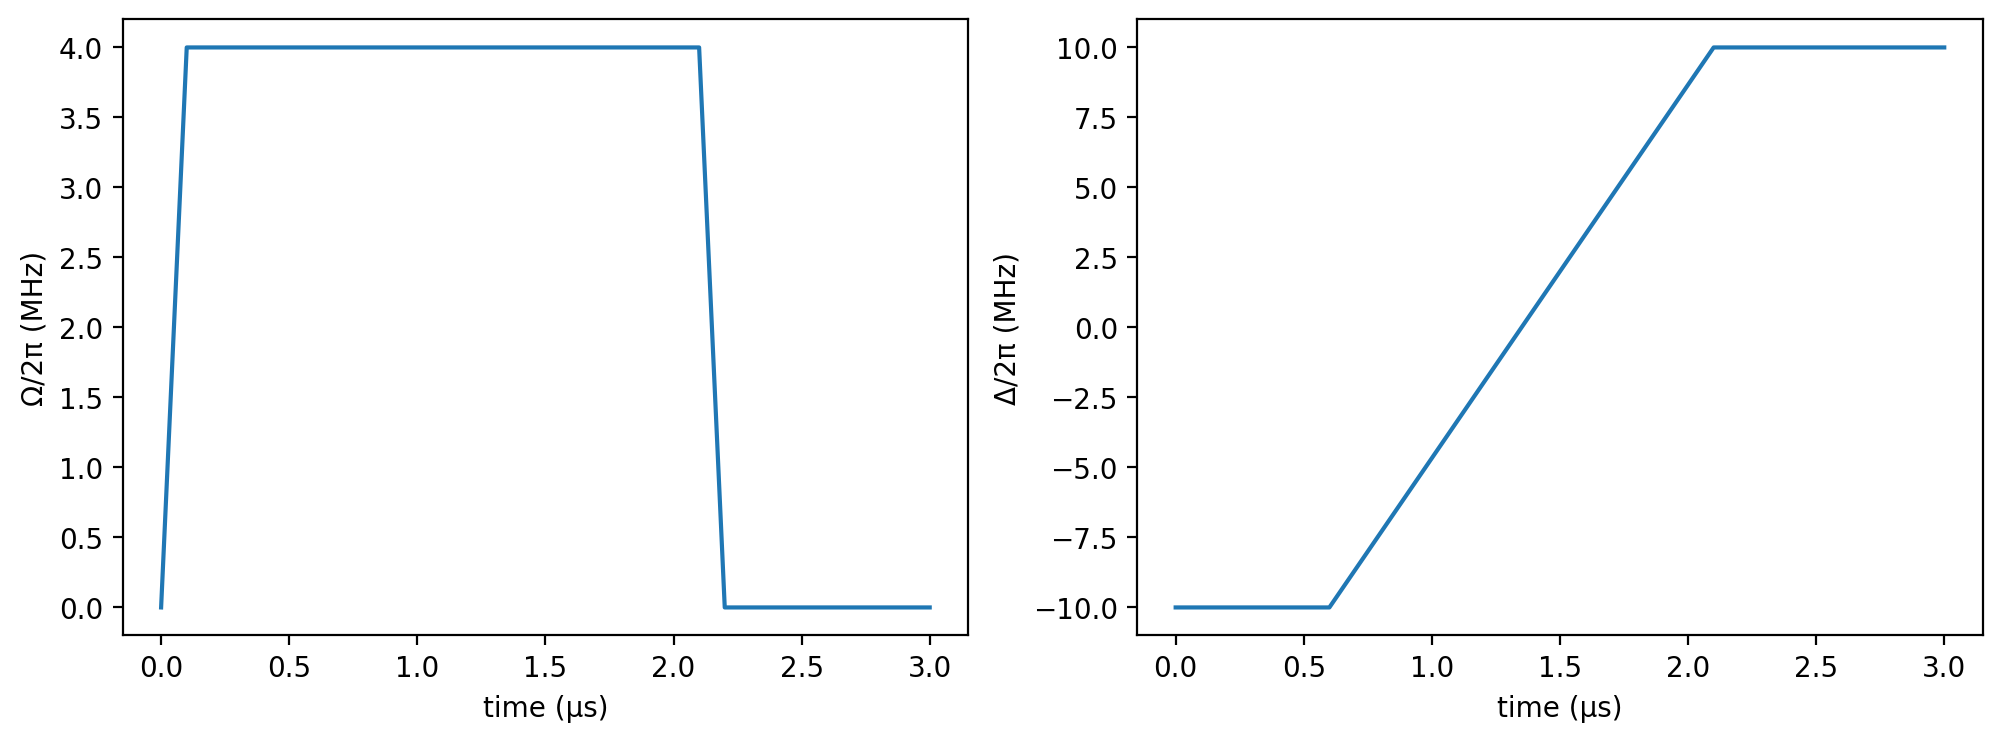

In [12]:
total_time = 3.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]);

U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

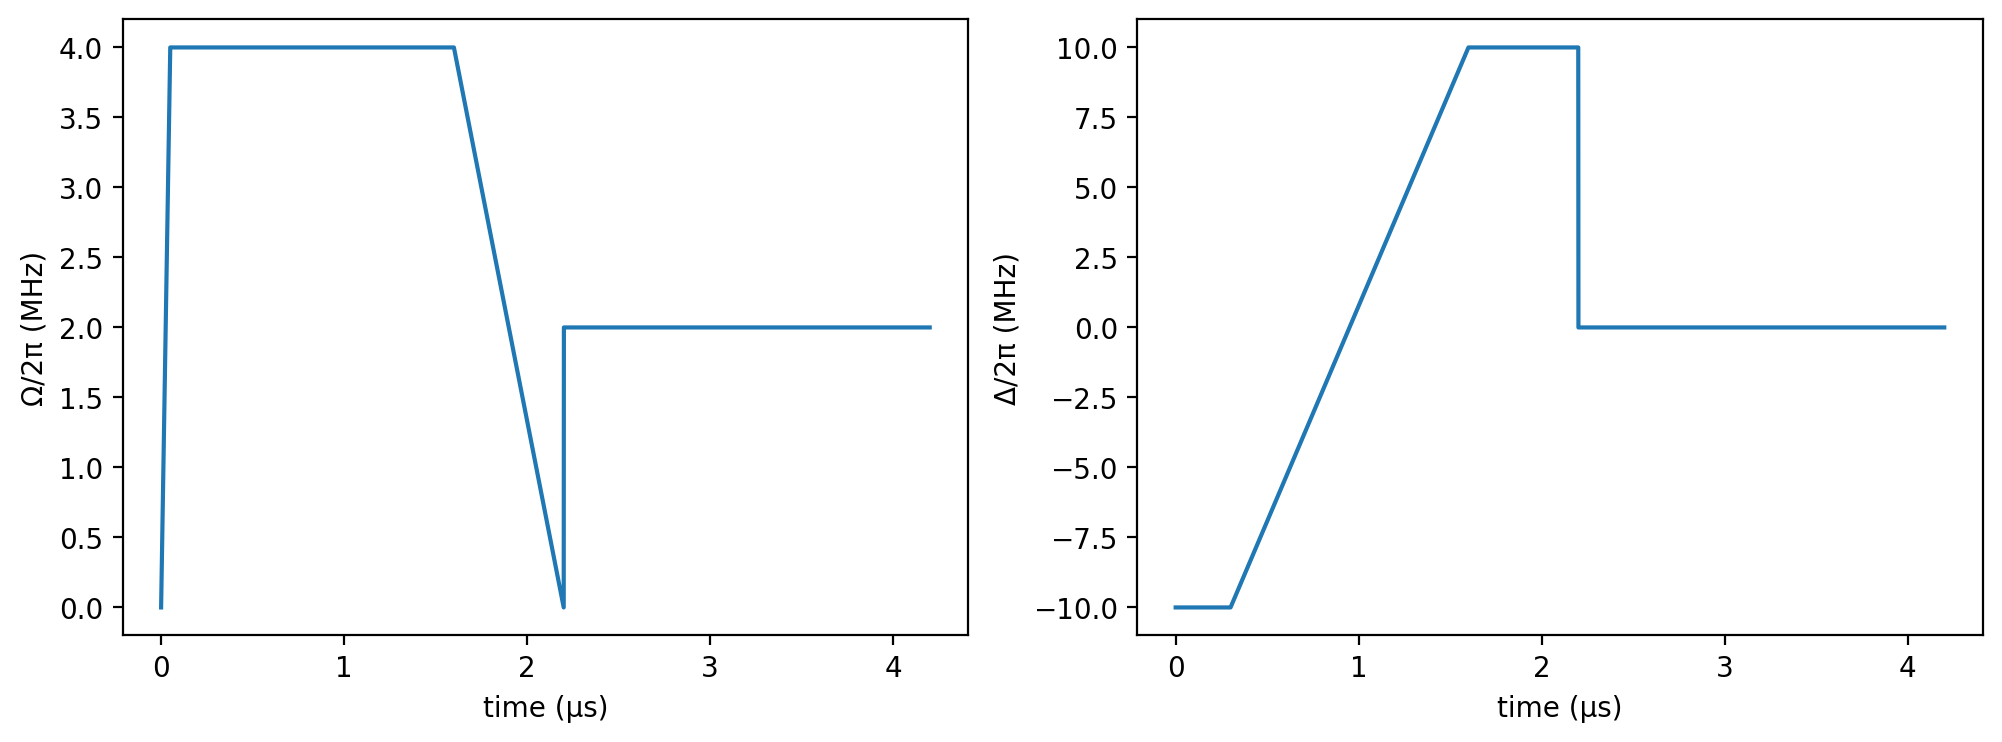

In [13]:
Δ1 = piecewise_linear(clocks = [0.0, 0.3, 1.6, 2.2], values = 2π * [-10.0, -10.0, 10.0, 10.0]);
Ω1 = piecewise_linear(clocks = [0.0, 0.05, 1.6, 2.2], values = 2π * [0.0, 4.0, 4.0, 0.0]);

Ω2 = constant(duration = 2.0, value = 2 * 2π);
Δ2 = constant(duration = 2.0, value = 0);

Ω_tot = append(Ω1, Ω2);
Δ_tot = append(Δ1, Δ2);

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω_tot)
Bloqade.plot!(ax2, Δ_tot)
ax1.set_ylabel("Ω/2π (MHz)")
ax2.set_ylabel("Δ/2π (MHz)")
fig

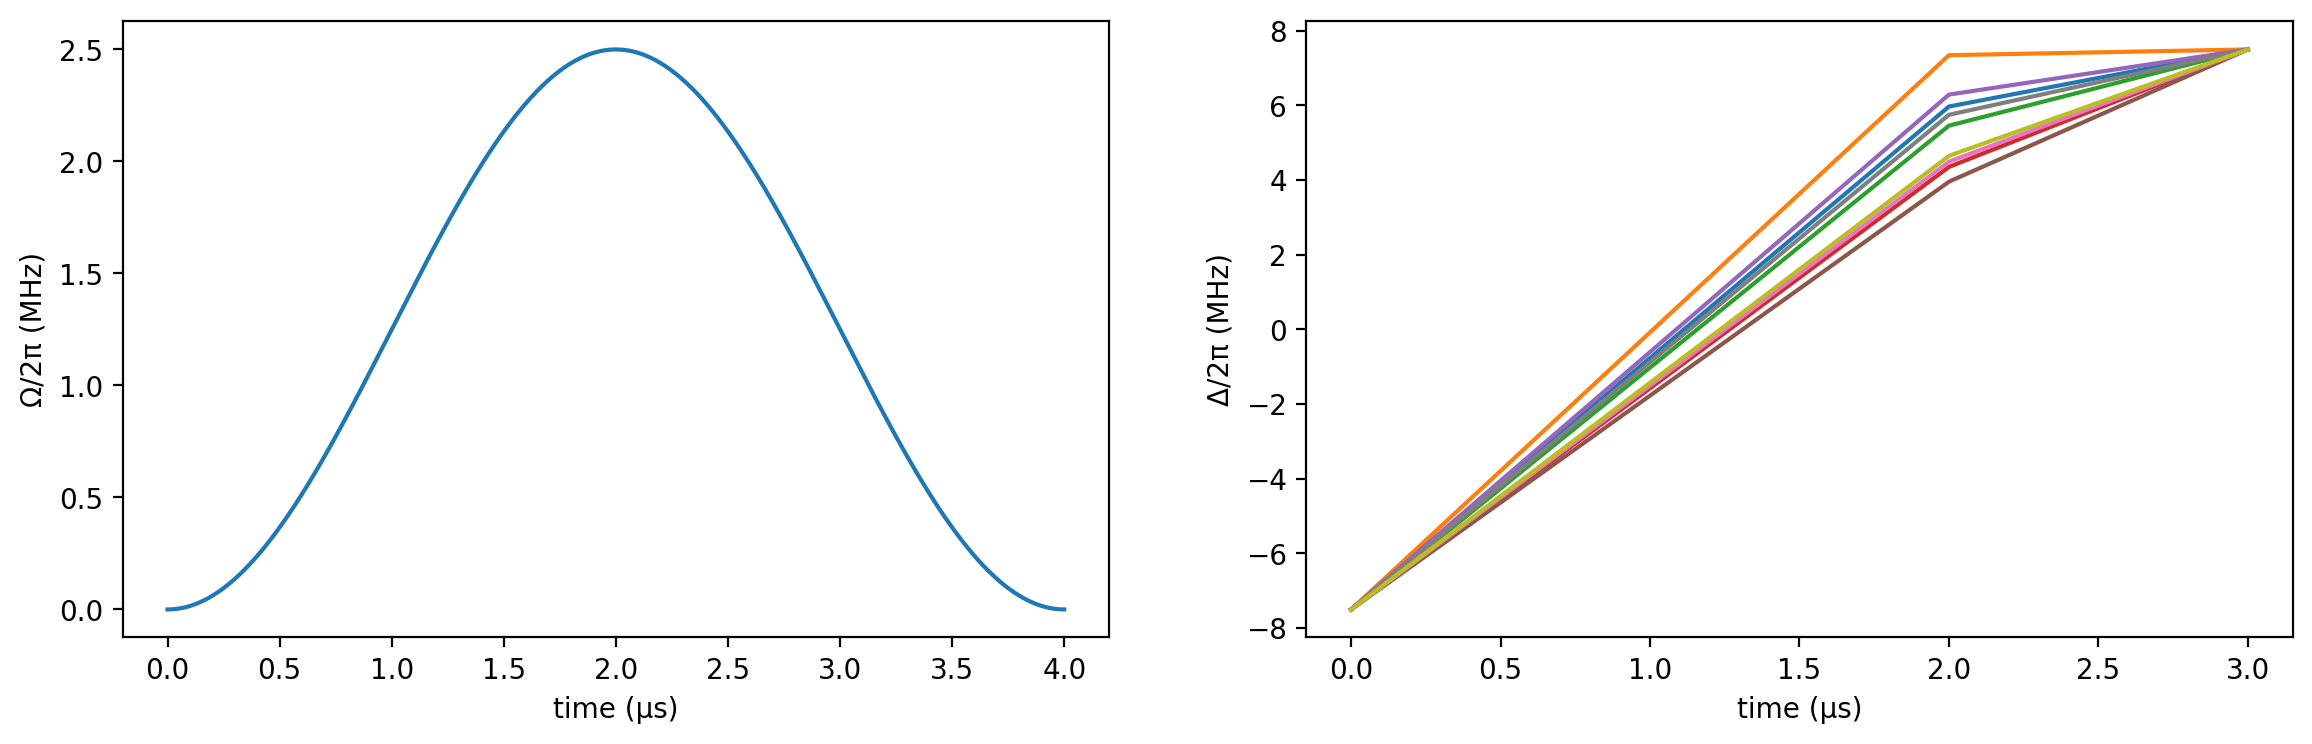

In [14]:
Ω_max = 2π * 2.5
Δ1_max = 3 * Ω_max
Δ2_max = 2 * Ω_max
t_max=4.0

nodes=9;

weights = [rand() for i in 1:nodes];

function build_adiabatic_sweep(Ω_max::Float64, Δ1_max::Float64, Δ2_max::Float64, t_max::Float64, weights::Vector{Float64})
    Ω = Waveform(t -> Ω_max * sin(pi * t / t_max)^2, duration = t_max)
    Δg = piecewise_linear(clocks = [0.0, total_time], values = [-Δ1_max, Δ1_max]);
    Δl = map(1:nodes) do idx
        return Δg+weights[idx]*piecewise_linear(clocks = [0.0,2/3* total_time, total_time], values = [0, Δ2_max,0])
    end
    return Ω, Δl
end

Ω,Δ = build_adiabatic_sweep(Ω_max, Δ1_max, Δ2_max, t_max, weights);

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
for i in 1:nodes
    Bloqade.plot!(ax2, Δ[i])
end
ax2.set_ylabel("Δ/2π (MHz)")
fig